# Betting Odds Data Analysis

This notebook provides visualizations and analysis of collected NBA betting odds data.

## Contents
1. Data Overview
2. Line Movement Visualization
3. Bookmaker Comparison
4. Market Efficiency Analysis
5. Data Quality Metrics

In [1]:
# Setup and imports
import sys
from pathlib import Path

# Add parent directory to path
sys.path.insert(0, str(Path.cwd().parent))

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from odds_core.database import async_session_maker
from odds_core.models import Event, Odds, OddsSnapshot
from sqlalchemy import select

# Set style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

print("✓ Imports loaded successfully")

✓ Imports loaded successfully


## 1. Data Overview

In [2]:
async def get_data_overview():
    """Get overview statistics of collected data."""
    async with async_session_maker() as session:
        # Count events
        events_query = select(Event)
        result = await session.execute(events_query)
        events = result.scalars().all()

        # Count snapshots
        snapshots_query = select(OddsSnapshot)
        result = await session.execute(snapshots_query)
        snapshots = result.scalars().all()

        # Count odds records
        odds_query = select(Odds)
        result = await session.execute(odds_query)
        odds = result.scalars().all()

        return {"events": events, "snapshots": snapshots, "odds": odds}


# Load data
data = await get_data_overview()

print(f"Total Events: {len(data['events'])}")
print(f"Total Snapshots: {len(data['snapshots'])}")
print(f"Total Odds Records: {len(data['odds'])}")
print(f"Average Odds per Snapshot: {len(data['odds']) / len(data['snapshots']):.1f}")

# Convert to DataFrames
events_df = pd.DataFrame(
    [
        {
            "event_id": e.id,
            "home_team": e.home_team,
            "away_team": e.away_team,
            "commence_time": e.commence_time,
            "status": e.status.value,
        }
        for e in data["events"]
    ]
)

odds_df = pd.DataFrame(
    [
        {
            "event_id": o.event_id,
            "bookmaker": o.bookmaker_key,
            "market": o.market_key,
            "outcome": o.outcome_name,
            "price": o.price,
            "point": o.point,
            "timestamp": o.odds_timestamp,
        }
        for o in data["odds"]
    ]
)

print("\n✓ DataFrames created")

Total Events: 777
Total Snapshots: 13600
Total Odds Records: 424220
Average Odds per Snapshot: 31.2

✓ DataFrames created


In [3]:
# Show sample data
print("Sample Events:")
display(events_df.head())

print("\nSample Odds:")
display(odds_df.head(10))

Sample Events:


,event_id,home_team,away_team,commence_time,status
0,072f959e31211e7c805451ce92a5f4e5,Indiana Pacers,Oklahoma City Thunder,2025-10-23 23:40:00+00:00,final
1,6f4f9851f7634f0b452c9153373deddf,Toronto Raptors,Milwaukee Bucks,2025-10-24 22:45:00+00:00,final
2,2115811d6d5915d1d9ab317396776cf7,Orlando Magic,Atlanta Hawks,2025-10-24 23:11:03+00:00,final
3,600dfc9979b72eeef44b5545ba9fe18f,New York Knicks,Boston Celtics,2025-10-24 23:43:11+00:00,final
4,af723c8d13c83ededaa33a065f24a5be,Brooklyn Nets,Cleveland Cavaliers,2025-10-24 23:43:29+00:00,final



Sample Odds:


,event_id,bookmaker,market,outcome,price,point,timestamp
0,072f959e31211e7c805451ce92a5f4e5,draftkings,h2h,Indiana Pacers,245,NaN,2025-10-23 21:44:28.116370+00:00
1,072f959e31211e7c805451ce92a5f4e5,draftkings,h2h,Oklahoma City Thunder,-305,NaN,2025-10-23 21:44:28.116370+00:00
2,072f959e31211e7c805451ce92a5f4e5,draftkings,spreads,Indiana Pacers,-115,7.5,2025-10-23 21:44:28.116370+00:00
3,072f959e31211e7c805451ce92a5f4e5,draftkings,spreads,Oklahoma City Thunder,-105,-7.5,2025-10-23 21:44:28.116370+00:00
4,072f959e31211e7c805451ce92a5f4e5,draftkings,totals,Over,-110,231.5,2025-10-23 21:44:28.116370+00:00
5,072f959e31211e7c805451ce92a5f4e5,draftkings,totals,Under,-110,231.5,2025-10-23 21:44:28.116370+00:00
6,072f959e31211e7c805451ce92a5f4e5,williamhill_us,h2h,Indiana Pacers,260,NaN,2025-10-23 21:44:28.116370+00:00
7,072f959e31211e7c805451ce92a5f4e5,williamhill_us,h2h,Oklahoma City Thunder,-335,NaN,2025-10-23 21:44:28.116370+00:00
8,072f959e31211e7c805451ce92a5f4e5,williamhill_us,spreads,Indiana Pacers,-115,7.5,2025-10-23 21:44:28.116370+00:00
9,072f959e31211e7c805451ce92a5f4e5,williamhill_us,spreads,Oklahoma City Thunder,-105,-7.5,2025-10-23 21:44:28.116370+00:00


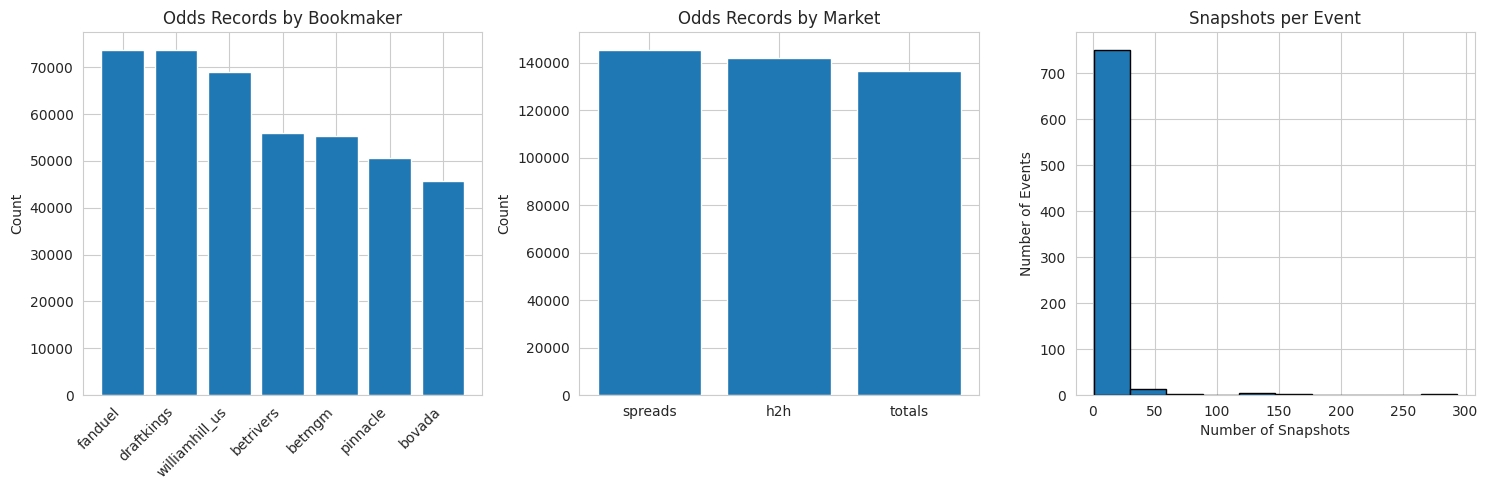

In [4]:
# Data distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Bookmaker distribution
bookmaker_counts = odds_df["bookmaker"].value_counts()
axes[0].bar(range(len(bookmaker_counts)), bookmaker_counts.values)
axes[0].set_xticks(range(len(bookmaker_counts)))
axes[0].set_xticklabels(bookmaker_counts.index, rotation=45, ha="right")
axes[0].set_title("Odds Records by Bookmaker")
axes[0].set_ylabel("Count")

# Market distribution
market_counts = odds_df["market"].value_counts()
axes[1].bar(market_counts.index, market_counts.values)
axes[1].set_title("Odds Records by Market")
axes[1].set_ylabel("Count")

# Snapshots per event
snapshots_per_event = (
    pd.DataFrame([{"event_id": s.event_id} for s in data["snapshots"]]).groupby("event_id").size()
)
axes[2].hist(snapshots_per_event.values, bins=10, edgecolor="black")
axes[2].set_title("Snapshots per Event")
axes[2].set_xlabel("Number of Snapshots")
axes[2].set_ylabel("Number of Events")

plt.tight_layout()
plt.show()

## 2. Line Movement Visualization

Visualize how odds change over time leading up to game start.

In [5]:
# Select a game with multiple snapshots
events_with_snapshots = odds_df.groupby("event_id")["timestamp"].nunique()
games_with_movement = events_with_snapshots[events_with_snapshots > 4]

if len(games_with_movement) == 0:
    print("No games with multiple snapshots found. Collect more historical data!")
else:
    sample_event_id = games_with_movement.index[0]
    sample_event = events_df[events_df["event_id"] == sample_event_id].iloc[0]

    print(f"Analyzing: {sample_event['away_team']} @ {sample_event['home_team']}")
    print(f"Game Time: {sample_event['commence_time']}")
    print(f"Snapshots: {games_with_movement[sample_event_id]}")

Analyzing: Washington Wizards @ Memphis Grizzlies
Game Time: 2025-12-21 01:11:00+00:00
Snapshots: 20


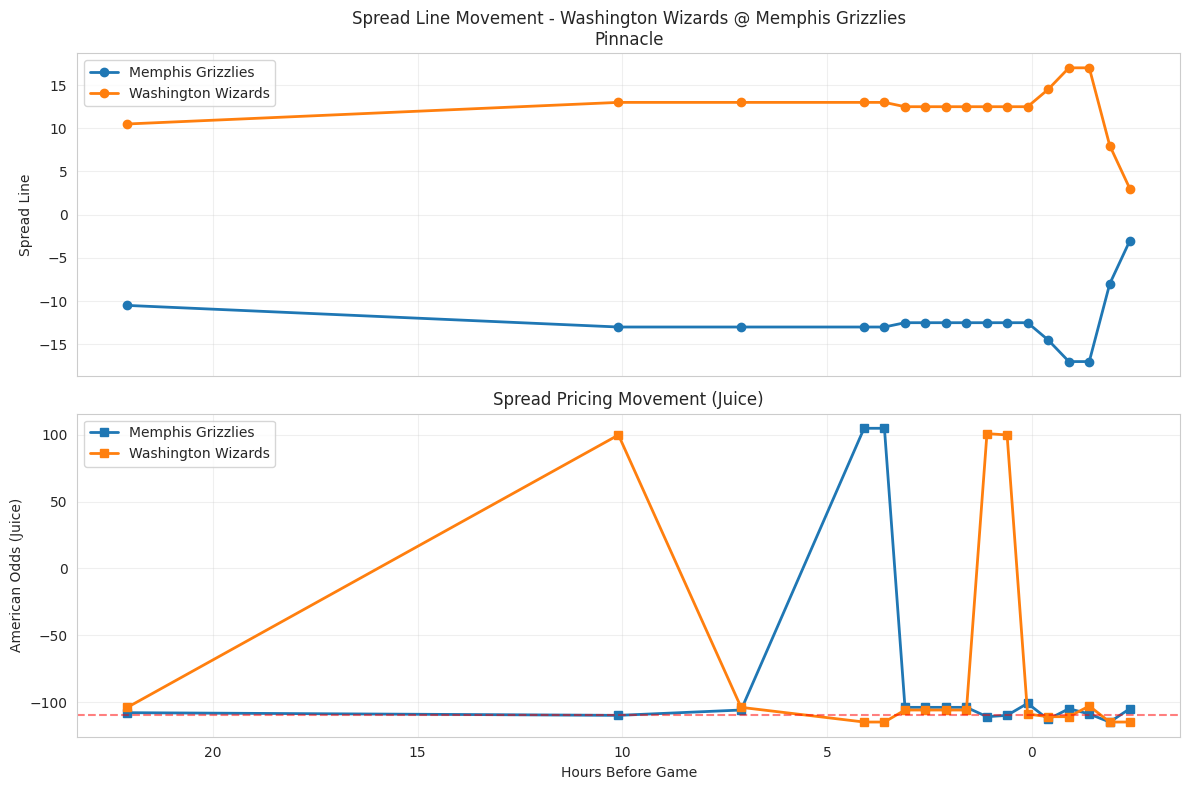

In [6]:
# Spread line movement for Pinnacle (sharp book)
if len(games_with_movement) > 0:
    event_odds = odds_df[
        (odds_df["event_id"] == sample_event_id)
        & (odds_df["bookmaker"] == "pinnacle")
        & (odds_df["market"] == "spreads")
    ].sort_values("timestamp")

    if len(event_odds) > 0:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

        # Calculate hours before game
        game_time = pd.Timestamp(sample_event["commence_time"])
        event_odds["hours_before"] = (
            game_time - pd.to_datetime(event_odds["timestamp"])
        ).dt.total_seconds() / 3600

        # Plot spread lines
        for outcome in event_odds["outcome"].unique():
            outcome_odds = event_odds[event_odds["outcome"] == outcome]
            ax1.plot(
                outcome_odds["hours_before"],
                outcome_odds["point"],
                marker="o",
                label=outcome,
                linewidth=2,
            )

        ax1.set_ylabel("Spread Line")
        ax1.set_title(
            f"Spread Line Movement - {sample_event['away_team']} @ {sample_event['home_team']}\nPinnacle"
        )
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax1.invert_xaxis()  # Time flows left to right

        # Plot prices (juice)
        for outcome in event_odds["outcome"].unique():
            outcome_odds = event_odds[event_odds["outcome"] == outcome]
            ax2.plot(
                outcome_odds["hours_before"],
                outcome_odds["price"],
                marker="s",
                label=outcome,
                linewidth=2,
            )

        ax2.set_xlabel("Hours Before Game")
        ax2.set_ylabel("American Odds (Juice)")
        ax2.set_title("Spread Pricing Movement (Juice)")
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.axhline(y=-110, color="red", linestyle="--", alpha=0.5, label="Standard -110")

        plt.tight_layout()
        plt.show()
    else:
        print("No Pinnacle spread data for this game")

In [7]:
odds_df

,event_id,bookmaker,market,outcome,price,point,timestamp
0,072f959e31211e7c805451ce92a5f4e5,draftkings,h2h,Indiana Pacers,245,NaN,2025-10-23 21:44:28.116370+00:00
1,072f959e31211e7c805451ce92a5f4e5,draftkings,h2h,Oklahoma City Thunder,-305,NaN,2025-10-23 21:44:28.116370+00:00
2,072f959e31211e7c805451ce92a5f4e5,draftkings,spreads,Indiana Pacers,-115,7.5,2025-10-23 21:44:28.116370+00:00
3,072f959e31211e7c805451ce92a5f4e5,draftkings,spreads,Oklahoma City Thunder,-105,-7.5,2025-10-23 21:44:28.116370+00:00
4,072f959e31211e7c805451ce92a5f4e5,draftkings,totals,Over,-110,231.5,2025-10-23 21:44:28.116370+00:00
...,...,...,...,...,...,...,...
424215,abc123def456,draftkings,h2h,Boston Celtics,-105,NaN,2026-02-14 16:47:16.852829+00:00
424216,abc123def456,draftkings,spreads,Los Angeles Lakers,-108,-2.5,2026-02-14 16:47:16.852829+00:00
424217,abc123def456,draftkings,spreads,Boston Celtics,-112,2.5,2026-02-14 16:47:16.852829+00:00
424218,abc123def456,draftkings,totals,Over,-112,219.0,2026-02-14 16:47:16.852829+00:00


In [8]:
odds_df[
    (odds_df["event_id"] == sample_event_id)
    & (odds_df["bookmaker"] == "pinnacle")
    & (odds_df["market"] == "totals")
].sort_values("timestamp")

,event_id,bookmaker,market,outcome,price,point,timestamp
212896,00483daf4c80ac131810a9d835477e11,pinnacle,totals,Over,-107,235.5,2025-12-20 03:05:33.501706+00:00
212897,00483daf4c80ac131810a9d835477e11,pinnacle,totals,Under,-107,235.5,2025-12-20 03:05:33.501706+00:00
212920,00483daf4c80ac131810a9d835477e11,pinnacle,totals,Over,-103,231.0,2025-12-20 15:05:26.788863+00:00
212921,00483daf4c80ac131810a9d835477e11,pinnacle,totals,Under,-109,231.0,2025-12-20 15:05:26.788863+00:00
212960,00483daf4c80ac131810a9d835477e11,pinnacle,totals,Over,-106,231.0,2025-12-20 18:05:11.853210+00:00
212961,00483daf4c80ac131810a9d835477e11,pinnacle,totals,Under,-106,231.0,2025-12-20 18:05:11.853210+00:00
213000,00483daf4c80ac131810a9d835477e11,pinnacle,totals,Over,-108,233.0,2025-12-20 21:05:31.223805+00:00
213001,00483daf4c80ac131810a9d835477e11,pinnacle,totals,Under,-104,233.0,2025-12-20 21:05:31.223805+00:00
213041,00483daf4c80ac131810a9d835477e11,pinnacle,totals,Under,-104,233.0,2025-12-20 21:35:20.616125+00:00
213040,00483daf4c80ac131810a9d835477e11,pinnacle,totals,Over,-108,233.0,2025-12-20 21:35:20.616125+00:00


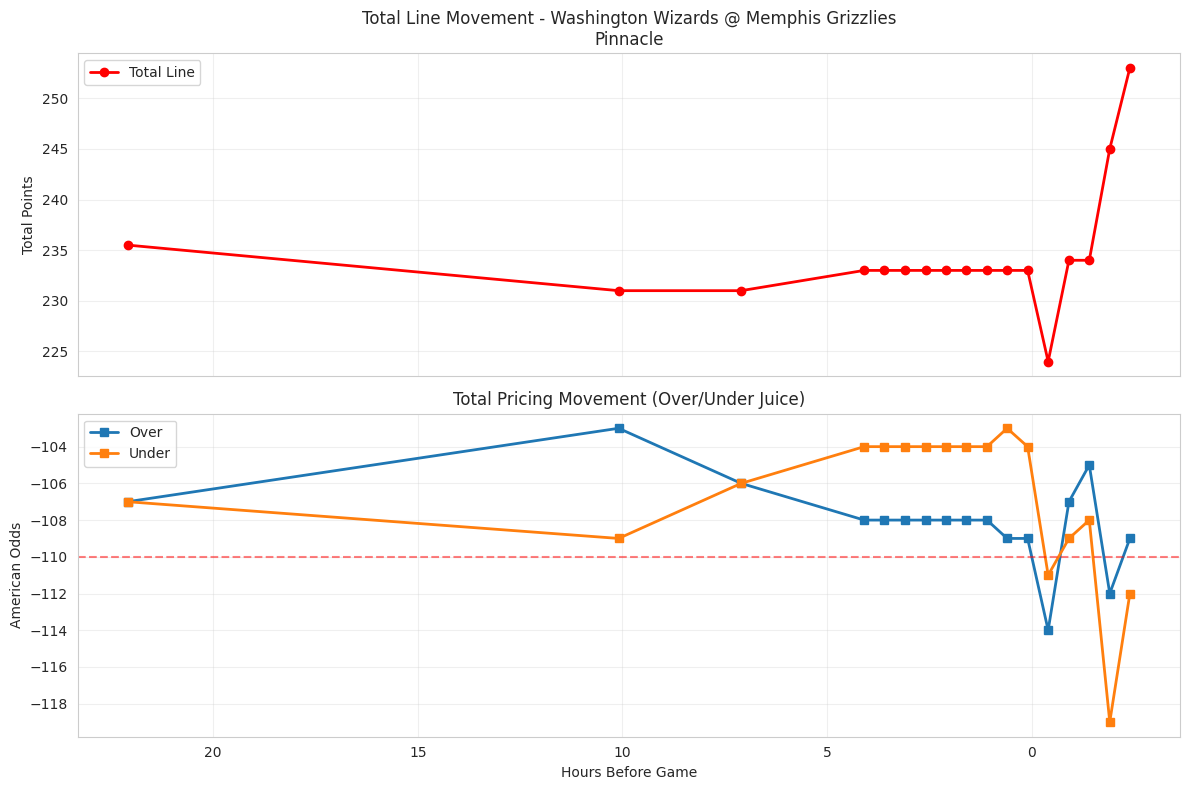

In [9]:
# Total (Over/Under) line movement
if len(games_with_movement) > 0:
    total_odds = odds_df[
        (odds_df["event_id"] == sample_event_id)
        & (odds_df["bookmaker"] == "pinnacle")
        & (odds_df["market"] == "totals")
    ].sort_values("timestamp")

    if len(total_odds) > 0:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

        # Calculate hours before game
        total_odds["hours_before"] = (
            game_time - pd.to_datetime(total_odds["timestamp"])
        ).dt.total_seconds() / 3600

        # Plot total line
        over_odds = total_odds[total_odds["outcome"] == "Over"]
        ax1.plot(
            over_odds["hours_before"],
            over_odds["point"],
            marker="o",
            color="red",
            linewidth=2,
            label="Total Line",
        )

        ax1.set_ylabel("Total Points")
        ax1.set_title(
            f"Total Line Movement - {sample_event['away_team']} @ {sample_event['home_team']}\nPinnacle"
        )
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax1.invert_xaxis()

        # Plot Over/Under pricing
        for outcome in total_odds["outcome"].unique():
            outcome_odds = total_odds[total_odds["outcome"] == outcome]
            ax2.plot(
                outcome_odds["hours_before"],
                outcome_odds["price"],
                marker="s",
                label=outcome,
                linewidth=2,
            )

        ax2.set_xlabel("Hours Before Game")
        ax2.set_ylabel("American Odds")
        ax2.set_title("Total Pricing Movement (Over/Under Juice)")
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.axhline(y=-110, color="red", linestyle="--", alpha=0.5, label="Standard -110")

        plt.tight_layout()
        plt.show()

## 3. Bookmaker Comparison

Compare odds across different bookmakers at a specific point in time.

Bookmaker Comparison at 2025-12-21 03:35:09.917334+00:00

Spread Odds:


point                                price  \
outcome        Memphis Grizzlies Washington Wizards Memphis Grizzlies   
bookmaker                                                               
bovada                     -12.5               12.5              -110   
draftkings                   7.5               -7.5              -154   
fanduel                      4.5               -4.5               162   
pinnacle                    -3.0                3.0              -105   
williamhill_us               5.5               -5.5              -110   

                                   
outcome        Washington Wizards  
bookmaker                          
bovada                       -110  
draftkings                    120  
fanduel                      -220  
pinnacle                     -115  
williamhill_us               -120

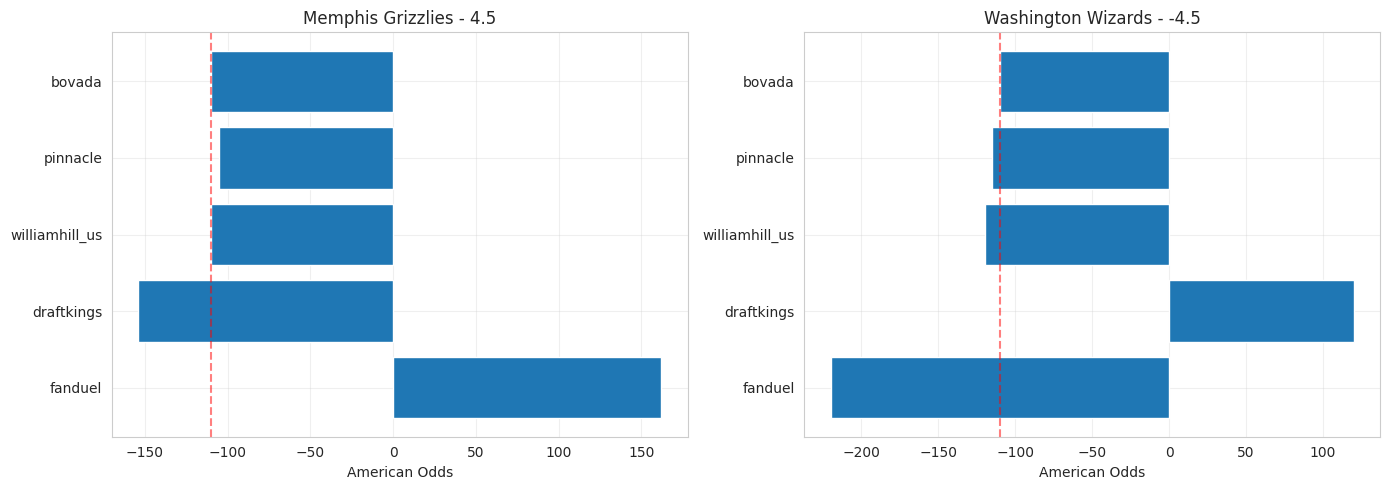

In [10]:
# Get latest snapshot for the sample event
if len(games_with_movement) > 0:
    latest_time = odds_df[odds_df["event_id"] == sample_event_id]["timestamp"].max()

    latest_spreads = odds_df[
        (odds_df["event_id"] == sample_event_id)
        & (odds_df["timestamp"] == latest_time)
        & (odds_df["market"] == "spreads")
    ]

    if len(latest_spreads) > 0:
        print(f"Bookmaker Comparison at {latest_time}")
        print("\nSpread Odds:")

        # Pivot for better display
        spread_comparison = latest_spreads.pivot_table(
            index="bookmaker", columns="outcome", values=["point", "price"], aggfunc="first"
        )

        display(spread_comparison)

        # Visualize spread distribution
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # Get unique outcomes
        outcomes = latest_spreads["outcome"].unique()

        for i, outcome in enumerate(outcomes[:2]):  # Show first two outcomes
            outcome_data = latest_spreads[latest_spreads["outcome"] == outcome]

            axes[i].barh(outcome_data["bookmaker"], outcome_data["price"])
            axes[i].set_xlabel("American Odds")
            axes[i].set_title(f"{outcome} - {outcome_data['point'].iloc[0]}")
            axes[i].axvline(x=-110, color="red", linestyle="--", alpha=0.5)
            axes[i].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

## 4. Market Efficiency Analysis

Calculate implied probabilities and identify potential value.

In [11]:
def american_to_probability(odds):
    """Convert American odds to implied probability."""
    if odds < 0:
        return abs(odds) / (abs(odds) + 100)
    else:
        return 100 / (odds + 100)


# Calculate implied probabilities for spreads
spread_odds = odds_df[odds_df["market"] == "spreads"].copy()
spread_odds["implied_prob"] = spread_odds["price"].apply(american_to_probability)


# Calculate vig (overround) for each bookmaker at each timestamp
def calculate_vig(group):
    if len(group) == 2:  # Need both sides
        total_prob = group["implied_prob"].sum()
        vig = (total_prob - 1.0) * 100
        return vig
    return None


vig_by_bookmaker = (
    spread_odds.groupby(["event_id", "timestamp", "bookmaker"]).apply(calculate_vig).reset_index()
)
vig_by_bookmaker.columns = ["event_id", "timestamp", "bookmaker", "vig_pct"]

# Average vig by bookmaker
avg_vig = vig_by_bookmaker.groupby("bookmaker")["vig_pct"].mean().sort_values()

print("Average Vig (%) by Bookmaker on Spreads:")
print(avg_vig)
print("\nLower vig = better for bettors")

Average Vig (%) by Bookmaker on Spreads:
bookmaker
pinnacle          3.132425
bovada            5.076707
draftkings        5.086993
williamhill_us    5.118456
fanduel           5.136263
betmgm            5.140974
betrivers         6.486943
Name: vig_pct, dtype: float64

Lower vig = better for bettors


/tmp/ipykernel_129320/1569295605.py:24: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  spread_odds.groupby(["event_id", "timestamp", "bookmaker"]).apply(calculate_vig).reset_index()


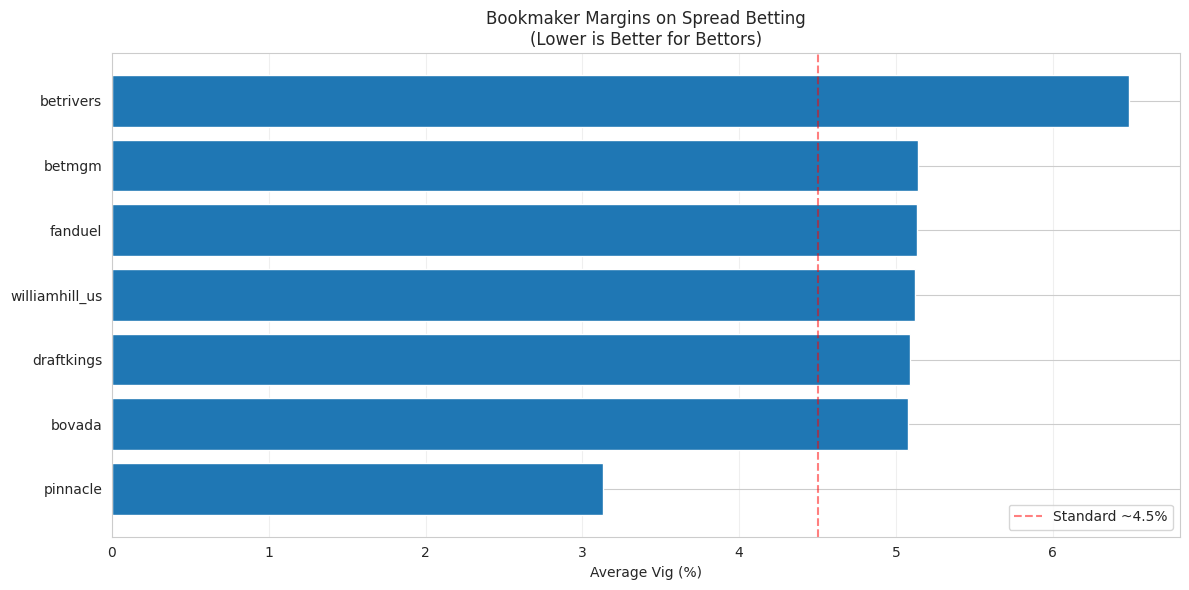


Note: Pinnacle typically has the lowest vig (sharpest book)
Retail books (DK, FD, MGM) typically have higher vig but offer promos


In [12]:
# Visualize vig distribution
plt.figure(figsize=(12, 6))
plt.barh(range(len(avg_vig)), avg_vig.values)
plt.yticks(range(len(avg_vig)), avg_vig.index)
plt.xlabel("Average Vig (%)")
plt.title("Bookmaker Margins on Spread Betting\n(Lower is Better for Bettors)")
plt.axvline(x=4.5, color="red", linestyle="--", alpha=0.5, label="Standard ~4.5%")
plt.legend()
plt.grid(True, alpha=0.3, axis="x")
plt.tight_layout()
plt.show()

print("\nNote: Pinnacle typically has the lowest vig (sharpest book)")
print("Retail books (DK, FD, MGM) typically have higher vig but offer promos")

## 5. Data Quality Metrics

In [13]:
# Check for data completeness
print("Data Completeness:")
print(f"Total Events: {len(events_df)}")
print(f"Events with Odds: {odds_df['event_id'].nunique()}")
print(f"Coverage: {odds_df['event_id'].nunique() / len(events_df) * 100:.1f}%")

# Check snapshot distribution over time
odds_df["date"] = pd.to_datetime(odds_df["timestamp"]).dt.date
snapshots_per_day = odds_df.groupby("date")["timestamp"].nunique()

print("\nSnapshot Timeline:")
print(f"First snapshot: {odds_df['timestamp'].min()}")
print(f"Latest snapshot: {odds_df['timestamp'].max()}")
print(f"Days with data: {len(snapshots_per_day)}")

# Missing data by bookmaker
expected_odds_per_event = (
    len(odds_df["bookmaker"].unique()) * 3 * 2
)  # bookmakers × markets × outcomes
actual_odds_per_event = odds_df.groupby("event_id").size()

print(f"\nExpected odds per event snapshot: {expected_odds_per_event}")
print(f"Actual average: {actual_odds_per_event.mean():.1f}")
print(f"Completeness: {actual_odds_per_event.mean() / expected_odds_per_event * 100:.1f}%")

Data Completeness:
Total Events: 777
Events with Odds: 777
Coverage: 100.0%

Snapshot Timeline:
First snapshot: 2025-10-21 02:10:00+00:00
Latest snapshot: 2026-02-14 16:47:16.852829+00:00
Days with data: 113

Expected odds per event snapshot: 42
Actual average: 546.0
Completeness: 1299.9%


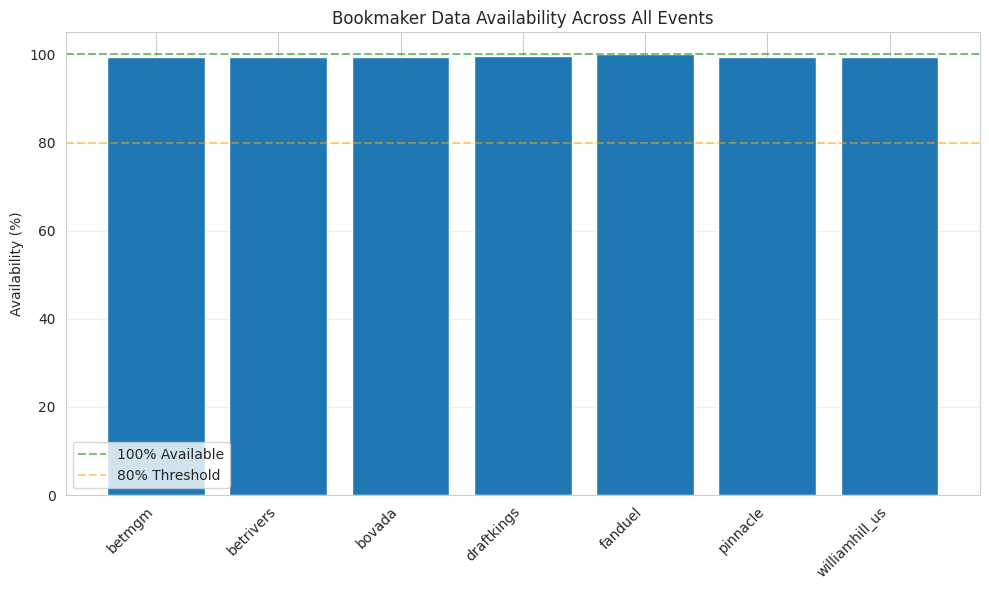

In [14]:
# Bookmaker availability across events
bookmaker_availability = odds_df.groupby(["event_id", "bookmaker"]).size().unstack(fill_value=0)
bookmaker_availability = (bookmaker_availability > 0).sum() / len(bookmaker_availability) * 100

plt.figure(figsize=(10, 6))
plt.bar(range(len(bookmaker_availability)), bookmaker_availability.values)
plt.xticks(
    range(len(bookmaker_availability)), bookmaker_availability.index, rotation=45, ha="right"
)
plt.ylabel("Availability (%)")
plt.title("Bookmaker Data Availability Across All Events")
plt.axhline(y=100, color="green", linestyle="--", alpha=0.5, label="100% Available")
plt.axhline(y=80, color="orange", linestyle="--", alpha=0.5, label="80% Threshold")
plt.legend()
plt.grid(True, alpha=0.3, axis="y")
plt.tight_layout()
plt.show()

## Summary

This notebook demonstrates:
- ✓ Data collection and storage is working
- ✓ Line movements are captured over time
- ✓ Multiple bookmakers are tracked
- ✓ Market efficiency can be analyzed
- ✓ Data quality is monitored

### Next Steps
1. Collect more historical data (run full 166-game backfill)
2. Continue live data collection
3. Build backtesting framework
4. Develop betting strategies
5. Calculate closing line value (CLV)